## Create covariance matrix of InSAR uncertainty

In [42]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [53]:
def llh2local(llh, origin):
    """
    Python translation of Peter Cervelli's llh2local.
    Converts Longitude/Latitude to Local XY in kilometers.
    
    Parameters:
    llh: np.array of shape (N, 2) or (N, 3) -> [lon, lat, (height)]
    origin: list or array -> [lon0, lat0, (height0)]
    
    Returns:
    xy: np.array of shape (N, 2) -> [x_km, y_km]
    """
    # Set ellipsoid constants (WGS84)
    a = 6378137.0
    e = 0.08209443794970
    
    # Convert input to numpy array and then to radians
    llh = np.atleast_2d(llh).astype(float) * np.pi / 180
    origin = np.array(origin).astype(float) * np.pi / 180
    
    # Initialize output array (N, 2)
    n_points = llh.shape[0]
    xy = np.zeros((n_points, 2))
    
    # MATLAB: z = llh(2,:) ~= 0; (Find points where latitude is NOT zero)
    # We index column 1 for latitude in Python
    not_equator = llh[:, 1] != 0
    equator = ~not_equator
    
    # --- Projection for points NOT on the equator ---
    lon = llh[not_equator, 0]
    lat = llh[not_equator, 1]
    lon0 = origin[0]
    lat0 = origin[1]
    
    dlambda = lon - lon0
    
    # Meridian Distance calculation
    def get_M(phi):
        return a * (
            (1 - e**2/4 - 3*e**4/64 - 5*e**6/256) * phi -
            (3*e**2/8 + 3*e**4/32 + 45*e**6/1024) * np.sin(2*phi) +
            (15*e**4/256 + 45*e**6/1024) * np.sin(4*phi) -
            (35*e**6/3072) * np.sin(6*phi)
        )

    M = get_M(lat)
    M0 = get_M(lat0)
    
    N = a / np.sqrt(1 - e**2 * np.sin(lat)**2)
    E = dlambda * np.sin(lat)
    
    # cot(x) = 1/tan(x)
    cot_lat = 1.0 / np.tan(lat)
    
    xy[not_equator, 0] = N * cot_lat * np.sin(E)
    xy[not_equator, 1] = M - M0 + N * cot_lat * (1 - np.cos(E))
    
    # --- Handle special case of latitude = 0 (equator) ---
    if np.any(equator):
        dlambda_eq = llh[equator, 0] - lon0
        xy[equator, 0] = a * dlambda_eq
        xy[equator, 1] = -M0
        
    # Convert from meters to km
    return xy / 1000.0

In [2]:
def load_insar_data(filename):
    file = loadmat(filename, squeeze_me=True)
    insar_dict = {key: file[key] for key in file.keys() if key in file}
    
    return insar_dict

In [4]:
# Load InSAR track
d142a1 = load_insar_data('../DT142A1all.mat')
a04a1 = load_insar_data('../AT04A1all.mat')

print(a04a1.keys())
print(a04a1['velo'].shape, d142a1['velo'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'G_insar', 'az', 'inc', 'lat', 'lon', 'losx', 'losy', 'losz', 'maskDR', 'maskHaiti', 'maskhisp', 'velo', 'velostd'])
(20, 42) (25, 20)


In [71]:
# add reference point for each track
d142a1['origin'] =  [-72.515, 19.264, 1]; # DESS
a04a1['origin'] = [-72.308605, 18.528678, 1];  # VOIL

d142a1['name'] = "d142a1"
a04a1['name'] = "a04a1"

Here, we use d142a1 track as the example

In [70]:
insar = d142a1

# 1. Prepare xy array [lon, lat, 1]
lon_flat = insar['lon'].flatten()
lat_flat = insar['lat'].flatten()
ones_vec = np.ones_like(lon_flat)

xy = np.column_stack((lon_flat, lat_flat, ones_vec))
print(xy)

[[-73.35565053  20.06669024   1.        ]
 [-73.30387153  20.0574128    1.        ]
 [-73.24622662  20.04706579   1.        ]
 ...
 [-72.56335475  18.67020424   1.        ]
 [-72.49568749  18.65750509   1.        ]
 [-72.43365131  18.64584037   1.        ]]


In [55]:
# 2. Coordinate Transformation (llh2local)
new_coord = llh2local(xy, insar['origin'][0:2]) 

# 3. Load and process std
velostd = insar['velostd'].flatten() # unit: mm

# 4. Remove NaNs
ind = ~np.isnan(velostd)
new_coord_out = new_coord[ind, :]
velostd_out = velostd[ind]

# 5. Variance matrix
var = velostd_out**2
var_diag = np.diag(var)

# 6. Calculate Distances
new_d = cdist(new_coord_out, np.array(insar['origin'][0:2]).reshape(1, -1))
dist2ref = np.diag(new_d.flatten()) # Match MATLAB's diag(new_d) logic

# Pairwise distances between pixels
dist2pixel = cdist(new_coord_out, new_coord_out)
dist2pixel2 = cdist(new_coord, new_coord)

In [72]:
print(np.mean(dist2pixel), np.mean(dist2pixel2))

57.82706857595279 71.48185121539672


# Step 1: Set up the initial parameters

In [73]:
from scipy.spatial.distance import pdist

In [74]:
# Calculate pairwise distances (hEff1)
hEff1 = pdist(new_coord_out) 

# Calculate raw variances (rawVario1)
y = var.flatten()
n = len(y)
rawVario1 = []
for i in range(n):
    diff = 0.5 * (y[i] - y[i+1:])**2
    rawVario1.extend(diff)
rawVario1 = np.array(rawVario1)


In [75]:
# Define Binning Strategy (xbin)
rvar = np.max(hEff1) / 2
step = rvar / 10  # 15-5 = 10

xbin1 = np.arange(0, rvar + 4, 4) # [0:4:rvar]
xbin2 = np.linspace(0, np.ceil(step/3), 5)
xbin = np.sort(np.concatenate([xbin1, xbin2]))
xbin = np.array([0.01, 0.05, 0.075, 0.1] + xbin.tolist())
xbin = np.unique(xbin) # Clean up duplicates

In [76]:
# Experimental Variogram (expvario equivalent)
# This bins the raw data and calculates the mean for each distance bin
hb = [] # center of distance bins
vb = [] # mean variance in bins

for i in range(len(xbin)-1):
    mask = (hEff1 >= xbin[i]) & (hEff1 < xbin[i+1])
    if np.any(mask):
        hb.append(np.mean(hEff1[mask]))
        vb.append(np.mean(rawVario1[mask]))

hb = np.array(hb)
vb = np.array(vb)

# Step 2: get a & b value

In [78]:
# Setup Parameters
a = 40
b = 0.5e1  
C = 0     # Nugget

In [79]:
# 2. Calculate Models
# We calculate the model using hb (binned distances) for a clean line plot and hEff1 (raw distances) 
vmodel_binned = b * (1 - np.exp(-(hb / a))) + C
vmodel_raw = b * (1 - np.exp(-(hEff1 / a))) + C

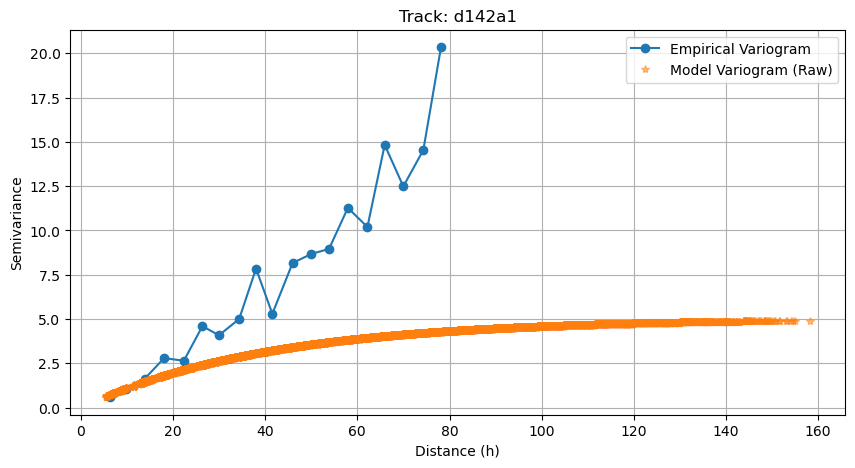

In [86]:
# 3. Create the first plot (C=0 implicitly)
plt.figure(figsize=(10, 5))
plt.plot(hb, vb, '-o', label='Empirical Variogram')
# Plotting the raw model as dots (caution: slow if hEff1 is huge)
plt.plot(hEff1, vmodel_raw, '*', markersize=6, alpha=0.5, label='Model Variogram (Raw)')
plt.grid(True)
plt.title(f"Track: {insar.get('name')}") 
plt.xlabel("Distance (h)")
plt.ylabel("Semivariance")
plt.legend()
plt.show()

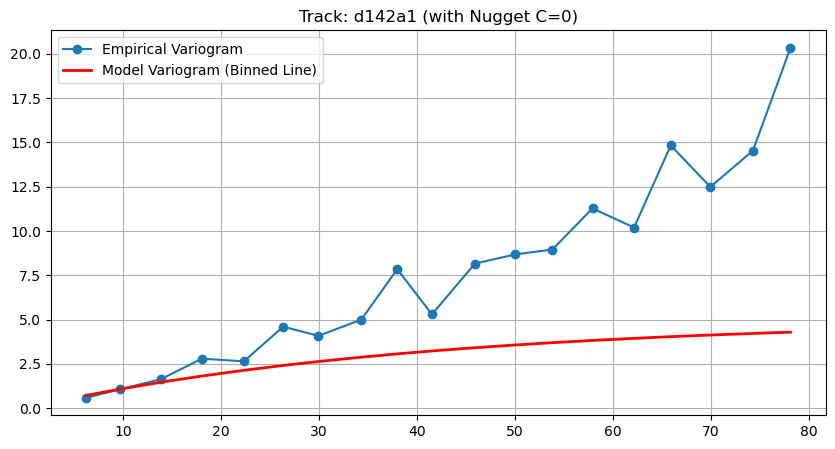

In [81]:
# 4. Create the second plot (with Nugget C)
# (Note: In your MATLAB snippet, you reset vmodel with C, but C was 0)
plt.figure(figsize=(10, 5))
plt.plot(hb, vb, '-o', label='Empirical Variogram')
plt.plot(hb, vmodel_binned, 'r-', linewidth=2, label='Model Variogram (Binned Line)')
plt.grid(True)
plt.title(f"Track: {insar.get('name')} (with Nugget C={C})")
plt.legend()
plt.show()

In [ ]:
# --- 1. Covariance Matrix Calculation ---
# b is the sill, a is the range, C is the nugget
# C_h is the covariance model: C(h) = sill * exp(-h/a)
C_h = b * np.exp(-(dist2pixel2 / a))

# Add the nugget effect to the diagonal
C_h2 = C_h + C * np.eye(C_h.shape[0])

In [83]:
# Save as a .mat file
filename = f'Cov_InSAR_{insar.get('name')}.mat'
savemat(filename, {'C_h2': C_h2})
print(f"Covariance matrix saved to {filename}")

Covariance matrix saved to Cov_InSAR_d142a1.mat


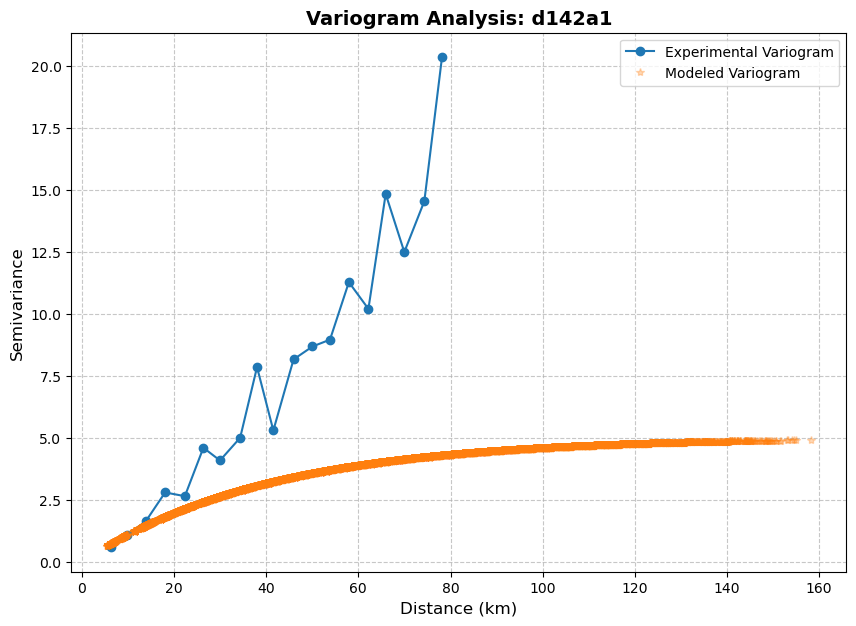

In [85]:
plt.figure(figsize=(10, 7))

# Plot Experimental Variogram
plt.plot(hb, vb, '-o', label='Experimental Variogram', markersize=6)

# Plot Modeled Variogram
plt.plot(hEff1, vmodel_raw, '*', label='Modeled Variogram', markersize=6, alpha=0.3)

# Formatting
plt.title(f'Variogram Analysis: {insar.get('name')}', fontsize=14, fontweight='bold')
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Semivariance', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# # Save the figure with 300 DPI
# output_file = f'variogram_analysis_{insar.get('name')}.png'
# plt.savefig(output_file, dpi=300, bbox_inches='tight')
# plt.show()

# print(f"Figure saved as {output_file}")